#### Author
Victor Aleksandrin

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=7fd764a4d88643feb275ff4ab37911c6)

#### Idea
Build simple Hugging Face baseline. 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view?usp=sharing) (not to be shared outside of the project!)

#### Result
See the plot below. Cross-validation accuracy is increasing with data set size. Final accuracy of baseline model approx 79.2

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    TrainingArguments, Trainer, 
    AdamW, get_scheduler,
    AutoModelForSequenceClassification,
    AutoTokenizer
)

import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import yaml
from importlib import import_module

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from typing import Dict, Any, Tuple, List, Union, Callable

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer as Pl_trainer
from pytorch_lightning import seed_everything, Callback
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

seed_everything(42)

42

### Read data

In [2]:
DATA_PATH = '../data/20190110_train_4500.csv'

In [3]:
dataset = pd.read_csv(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


In [5]:
le = LabelEncoder()

dataset["label"] = le.fit_transform(dataset["sentiment"])

### Config

In [6]:
def build_object(
    object_cfg: Dict[str, Any], 
    is_hugging_face: bool = False, 
    **kwargs: Dict[str, Any]
) -> Callable:
    if "class" not in object_cfg.keys():
        raise ValueError("class key schould be in config")

    if "params" in object_cfg.keys():
        params = object_cfg["params"]

        for key, val in params.items():
            kwargs[key] = val
    else:
        params = {}
    
    if is_hugging_face:
        return get_instance(object_cfg["class"]).from_pretrained(**kwargs)
    
    return get_instance(object_cfg["class"])(**kwargs)


def get_instance(object_path: str) -> Callable:

    module_path, class_name = object_path.rsplit(".", 1)
    module = import_module(module_path)

    return getattr(module, class_name)

In [7]:
pl_cfg_str = """
epochs: 3
train_batch_size: 32
val_batch_size: 64
seed: 42

model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        num_labels: 3

optimizer:
    class: transformers.AdamW
    params:
        lr: 0.00005
        weight_decay: 0.001

scheduler:
    params:
        name: linear
        num_warmup_steps: 500
"""

huggingface_cfg_str = """
training_args:
    class: transformers.TrainingArguments
    params:
        output_dir: './test_trainer'
        num_train_epochs: 3
        per_device_train_batch_size: 32
        per_device_eval_batch_size: 64
        warmup_steps: 500                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        weight_decay: 0.001
        logging_steps: 10
        evaluation_strategy: epoch


model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        num_labels: 3
"""

In [8]:
pl_cfg = yaml.safe_load(pl_cfg_str)
huggingface_cfg = yaml.safe_load(huggingface_cfg_str)

### Preprocess/split

In [9]:
class FinNewsDataset(Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: list):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        
        return item
    
    def __len__(self) -> int:
        return len(self.labels)

In [10]:
def prepare_dataset(cfg: Dict[str, Any], data: list, labels: list) -> Dataset:
    
    tokenizer = build_object(cfg["tokenizer"], is_hugging_face=True)
    
    encodings = tokenizer(data, truncation=True, padding=True)
    
    return FinNewsDataset(encodings, labels)

In [11]:
def split_train_val(dataset: pd.DataFrame, test_size: float = 0.2) -> Tuple[list, ...]:
    train_data, val_data, train_labels, val_labels = train_test_split(
        dataset["title"].values, 
        dataset["label"].values,
        test_size=test_size
    )
    
    return train_data.tolist(), val_data.tolist(), train_labels.tolist(), val_labels.tolist()

In [12]:
train_data, val_data, train_labels, val_labels = split_train_val(dataset)

## Train pipeline

### Hugging Face api

In [13]:
def train_huggin_face_pipeline( 
    cfg,
    train_dataset: Dataset, 
    val_dataset: Dataset
):
    
    model = build_object(cfg["model"], is_hugging_face=True)
    
    training_args = build_object(cfg["training_args"])
    
    metric = load_metric("accuracy")
    
    def compute_metrics(eval_pred: tuple) -> dict:
    
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        return metric.compute(predictions=predictions, references=labels)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    trainer.train()

In [14]:
hg_train_dataset = prepare_dataset(huggingface_cfg, train_data, train_labels)
hg_val_dataset = prepare_dataset(huggingface_cfg, val_data, val_labels)

In [15]:
train_huggin_face_pipeline(huggingface_cfg, hg_train_dataset, hg_val_dataset)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.843900,0.750641,0.720088
2,0.570300,0.533776,0.795829
3,0.440700,0.527450,0.812294


### Pytorch-Lightning api

In [16]:
class SentimentPipeline(pl.LightningModule):
    """Class for training text classification models"""

    def __init__(self, cfg: Dict[str, Any], num_training_steps: int):
        super().__init__()
        
        self.cfg = cfg
        self.model = build_object(cfg["model"], is_hugging_face=True)
        self.metric = load_metric("accuracy")
        self.num_training_steps = num_training_steps
        
        self.metrics = []

    def configure_optimizers(self):
        optimizer = build_object(self.cfg["optimizer"], params=self.model.parameters())

        lr_scheduler = get_scheduler(
            optimizer=optimizer,
            num_training_steps=self.num_training_steps,
            **self.cfg["scheduler"]["params"]
        )

        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def forward(self, batch: Dict[str, Tensor]):
        return self.model(**batch)

    def training_step(self, batch: Dict[str, Tensor], batch_idx: int) -> Tensor:

        outputs = self.model(**batch)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "train_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "train_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        return outputs.loss

    def validation_step(self, batch: Dict[str, Tensor], batch_idx: int) -> None:

        with torch.no_grad():
            outputs = self.model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "val_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "val_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )

In [17]:
class MetricTracker(Callback):

    def __init__(self):
        self.collection = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": []
        }
    
    def _log_metrics(self, trainer, stage: str = "train"):
        for key in (f"{stage}_acc", f"{stage}_loss"):
            self.collection[key].append(trainer.callback_metrics[key].item())
        
    def on_validation_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "val")
    
    def on_train_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "train")

In [18]:
def train_pl_model(
    cfg: Dict[str, Any], 
    train_dataloader: DataLoader, 
    val_dataloader: DataLoader, 
    return_predictions: bool = False
) -> Union[Dict[str, Any], Tuple[Dict[str, Any], np.ndarray]]:
    
    seed_everything(cfg["seed"])
    
    num_training_steps = cfg["epochs"] * len(train_dataloader)
    
    pipeline = SentimentPipeline(cfg, num_training_steps)
    
    metric_tracker = MetricTracker()
        
    trainer = Pl_trainer(
        max_epochs=cfg["epochs"],
        gpus=1,
        callbacks=[metric_tracker],
        num_sanity_val_steps=0
    )

    trainer.fit(
        pipeline, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader
    )
    
    if return_predictions:
        outputs = trainer.predict(pipeline, val_dataloader)
        
        logits = torch.cat([p.logits for p in outputs])
        
        pred_labels = torch.argmax(logits, dim=-1).numpy()
        
        return metric_tracker.collection, pred_labels
    
    return metric_tracker.collection

In [19]:
pl_train_dataset = prepare_dataset(pl_cfg, train_data, train_labels)
pl_val_dataset = prepare_dataset(pl_cfg, val_data, val_labels)

In [20]:
train_dataloader = DataLoader(pl_train_dataset, batch_size=pl_cfg["train_batch_size"], shuffle=True)
val_dataloader = DataLoader(pl_val_dataset, batch_size=pl_cfg["val_batch_size"], shuffle=False)

In [21]:
scores, predictions = train_pl_model(pl_cfg, train_dataloader, val_dataloader, return_predictions=True)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 114it [00:00, ?it/s]

In [22]:
scores

{'train_loss': [1.0060083866119385, 0.5831866264343262, 0.4126529395580292],
 'val_loss': [0.7026982307434082, 0.5356720089912415, 0.5613539814949036],
 'train_acc': [0.48256930708885193, 0.7757343053817749, 0.8484765291213989],
 'val_acc': [0.7475301623344421, 0.7991218566894531, 0.8002195358276367]}

In [23]:
print(classification_report(pl_val_dataset.labels, predictions, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.79      0.90      0.84       307
     Neutral       0.75      0.49      0.59       172
    Positive       0.82      0.85      0.84       432

    accuracy                           0.80       911
   macro avg       0.79      0.75      0.76       911
weighted avg       0.80      0.80      0.79       911



### Cross-validation

In [24]:
def cross_val(
    cfg: Dict[str, Any], 
    dataset: pd.DataFrame, 
    n_splits: int = 3, 
    shuffle: bool = True
) -> List[float]:
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=17)
    
    data = dataset["title"].values
    labels = dataset["label"].values
    
    cv_accuracy = []
        
    for train_index, test_index in skf.split(data, labels):
        
        train_data, val_data = data[train_index], data[test_index]
        train_labels, val_labels = labels[train_index], labels[test_index]
        
        train_dataset = prepare_dataset(cfg, train_data.tolist(), train_labels.tolist())
        val_dataset = prepare_dataset(cfg, val_data.tolist(), val_labels.tolist())
        
        train_dataloader = DataLoader(train_dataset, batch_size=cfg["train_batch_size"], shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=cfg["val_batch_size"], shuffle=False)
        
        scores = train_pl_model(cfg, train_dataloader, val_dataloader)
        
        cv_accuracy.append(scores["val_acc"][-1])
    
        torch.cuda.empty_cache()
    
    return cv_accuracy

In [25]:
cv_accuracy = cross_val(pl_cfg, dataset)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
np.mean(cv_accuracy), np.std(cv_accuracy)

(0.7944664160410563, 0.005692356364049278)

## Val Learning Curve

In [27]:
def learning_curve(cfg: Dict[str, Any], dataset: pd.DataFrame, train_fracs: np.ndarray):
    
    train_sizes: List[int] = []
    val_scores: List[List[float]] = []
    
    num_points: int = len(train_fracs)
    
    for i in range(num_points):
        
        num_samples = int(len(dataset)*train_fracs[i])
        
        train_data = dataset[:num_samples]
        
        cv_score = cross_val(cfg, train_data)
        
        val_scores.append(cv_score)
        train_sizes.append(num_samples)
    
    return train_sizes, val_scores

In [28]:
train_sizes, val_scores = learning_curve(pl_cfg, dataset, np.linspace(.2, 1, 5))

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
# helper function

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

In [30]:
np.array(val_scores).mean(1)

array([0.46483629, 0.69686987, 0.76244235, 0.78588913, 0.79446642])

Text(0.5, 1.0, '4500 titles. distilbert-base-uncased learning curves')

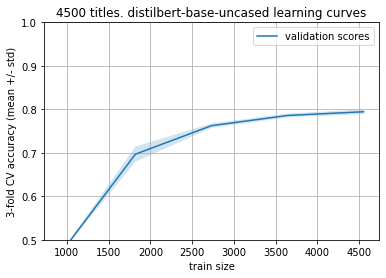

In [31]:
plot_with_err(train_sizes, np.array(val_scores), label='validation scores')
plt.xlabel('train size')
plt.ylabel('3-fold CV accuracy (mean +/- std)')
plt.legend()
plt.grid(True);
plt.ylim(.5, 1)
plt.title(f"4500 titles. {pl_cfg['model_name']} learning curves")